In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pickle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import signal
import nrrd
from PIL import Image

In [2]:
csv_path_stacks = "/work/jprieto/data/remote/EGower/hinashah/Analysis_Set_11012021/trachoma_normals_healthy_sev123_epi_stacks_16_544_test.csv"

df_stacks = pd.read_csv(csv_path_stacks)
df_stacks['class'] = (df_stacks['class'] >= 1).astype(int)

output_dir = "/work/jprieto/data/remote/EGower/jprieto/test_output/"


with open(os.path.join(output_dir, 'trachoma_normals_healthy_sev123_epi_stacks_16_544_test_10122021.pickle'), 'rb') as f:
    results_stacks = pickle.load(f)

pred_np, x_a_np, x_v_np, scores_np, x_v_pred_np = results_stacks
    
pred_np = np.array(pred_np)
x_a_np = np.array(x_a_np)
x_v_np = np.array(x_v_np)
scores_np = np.array(scores_np)
x_v_pred_np = np.array(x_v_pred_np)

print(pred_np.shape)
print(x_v_np.shape)
print(scores_np.shape)
print(x_v_pred_np.shape)

# results_epi.drop(results_epi[results_epi['patch_class'].isin(['Probable Epilation', 'Probable TT'])].index, inplace = True)
# results_epi = results_epi.reset_index()
# results_epi = results_epi.replace({'Healthy': 0, 'TT': 1, 'Epilation': 2})

(926, 2)
(926, 16, 256)
(926, 16, 1)
(926, 16, 2)


In [3]:
df_stacks["pred"] = np.argmax(pred_np, axis=1)
df_stacks["score"] = np.max(scores_np, axis=1)


In [5]:
csv_true_column = "class"
csv_prediction_column = "pred"
y_true_arr = [] 
y_pred_arr = []
for idx, row in df_stacks.iterrows():
  y_true_arr.append(row[csv_true_column])
  y_pred_arr.append(row[csv_prediction_column])


In [6]:
cnf_matrix = confusion_matrix(y_true_arr, y_pred_arr)
print(cnf_matrix)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print(cnf_matrix_norm)
print(classification_report(y_true_arr, y_pred_arr))

[[166  10]
 [133 617]]
[[0.94318182 0.05681818]
 [0.17733333 0.82266667]]
              precision    recall  f1-score   support

           0       0.56      0.94      0.70       176
           1       0.98      0.82      0.90       750

    accuracy                           0.85       926
   macro avg       0.77      0.88      0.80       926
weighted avg       0.90      0.85      0.86       926



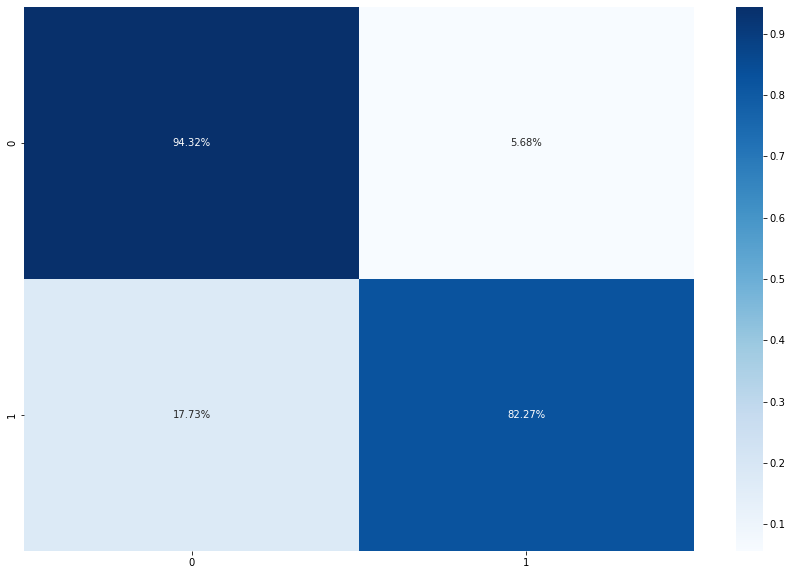

In [7]:
plt.figure(figsize=[15,10])
sns.heatmap(cnf_matrix_norm, annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [8]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(x_v_np)
df_stacks["pca_0"] = pca_fit[:,0]
df_stacks["pca_1"] = pca_fit[:,1]

ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_stacks["pca_0"], y=df_stacks["pca_1"], mode='markers', text=df_stacks["pred"], marker=dict(color=df_stacks["class"], size=(df_stacks["pred"]+1)*5, showscale=True)))
fig.update_layout(
    autosize=False,
    width=1200,
    height=800
)
fig

In [ ]:
df_miss_classified = df_stacks.query("pred != class")
df_classified = df_stacks.query("pred == class")
df_tt = df_stacks.query("class > 0 and pred == 0")

fig = go.FigureWidget(make_subplots(rows=1, cols=3, column_widths=[0.33, 0.33, 0.33], specs=[[{}, {}, {}]]))

fig.add_trace(go.Scatter(x=df_miss_classified["pca_0"], y=df_miss_classified["pca_1"], mode='markers', text=df_miss_classified["score"], marker=dict(color=df_miss_classified["score"], showscale=False, cmin=0, cmax=1)), row=1, col=1)
fig.add_trace(go.Scatter(x=df_classified["pca_0"], y=df_classified["pca_1"], mode='markers', text=df_classified["score"], marker=dict(color=df_classified["score"], showscale=False, cmin=0, cmax=1)), row=1, col=2)
fig.add_trace(go.Scatter(x=df_tt["pca_0"], y=df_tt["pca_1"], mode='markers', text=df_tt["score"], marker=dict(color=df_tt["score"], showscale=True, cmin=0, cmax=1)), row=1, col=3)


fig.update_layout(
    autosize=False,
    width=1500,
    height=600
)
fig

In [ ]:
print(df_miss_classified["score"].describe())
print(df_classified["score"].describe())
print(df_tt["score"].describe())

In [ ]:
df_healthy = df_stacks.query("patch_class == 0")
df_healthy["score"].describe()

In [ ]:
fig = go.FigureWidget(make_subplots(rows=2, cols=2, column_widths=[0.7, 0.3], specs=[[{'colspan': 2}, {}],[{},{}]]))

fig.add_trace(go.Scatter(x=df_stacks["pca_0"], y=df_stacks["pca_1"], mode='markers', text=df_stacks["score"], showlegend=False, marker=dict(
    color=df_stacks["class"], size=(df_stacks["pred"] + 1)*5, colorscale='sunset', showscale=True, opacity=1, line=dict(color='red', width=1)
)), row=1, col=1)
fig.add_trace(go.Scatter(mode='markers', showlegend=False, marker=dict(showscale=True, size=10, cmin=np.min(x_v_p_np), cmax=np.max(x_v_p_np), colorscale='sunset', line=dict(color='red', width=1))), row=2, col=1)
fig.add_trace(go.Scatter(mode='markers', marker=dict(color='LightSkyBlue', size=10), showlegend=False), row=2, col=1)
fig.add_trace(go.Image(), row=2, col=2)

fig.data[0].marker.showscale = True
fig.data[0].marker.colorbar.y = 0.8
fig.data[0].marker.colorbar.len = 0.5

fig.data[1].marker.showscale = True
fig.data[1].marker.colorbar.y = .2
fig.data[1].marker.colorbar.len = 0.5

fig.update_layout(
    autosize=False,
    width=1200,
    height=800
)

current_idx = {"idx": 0, "idx_f": 0, "img_np": []}

def update_study(trace, points, selector):
    if points.trace_name == 'trace 0' and len(points.point_inds) > 0:
        print("update_study", points)
        idx = points.point_inds[0]  
        x_feat_idx = np.array(x_v_features_np[idx]).reshape(-1, 256)
        x_feat_idx_pca = pca.transform(x_feat_idx)
        print(x_feat_idx_pca.shape)
#         scores_idx = np.array(scores[idx]).reshape(-1)
#         weights_idx = np.array(weights[idx]).reshape(-1)
        print(x_v_p_np.shape)
        df_idx = pd.DataFrame({
            "pca_0": x_feat_idx_pca[:,0],
            "pca_1": x_feat_idx_pca[:,1],
            "pred": np.array(np.argmax(x_v_p_np[idx], axis=1)).reshape(-1), 
            "score": np.array(x_s_np[idx]).reshape(-1)
#             ,
#             "scores": scores_idx,
#             "weights": weights_idx
            })

        with fig.batch_update():
            fig.data[1]['x'] = df_idx["pca_0"]
            fig.data[1]['y'] = df_idx["pca_1"]
            fig.data[1].marker.color = df_idx['pred']
            fig.data[1].text = ['s: {:f}, p: {:f}'.format(s, p) for s, p in zip(df_idx['score'], df_idx['pred'])]
#             fig.data[1].marker.cmin = np.max()
#             fig.data[1].marker.cmax = 1
            
            fig.data[2]['x'] = [df_stacks.loc[idx]["pca_0"]]
            fig.data[2]['y'] = [df_stacks.loc[idx]["pca_1"]]

            current_idx["idx"] = idx
            
            current_idx["img_np"] = nrrd.read(os.path.join("/work/jprieto/data/remote/EGower/", df_stacks.loc[idx]["img"]), index_order='C')[0]
            
fig.data[0].on_click(update_study)

def update_img(trace, points, selector):
    if points.trace_name == 'trace 1' and len(points.point_inds) > 0:
        print('update_img', points)
        idx_f = points.point_inds[0] 
        current_idx["idx_f"] = idx_f
        with fig.batch_update():
#             fig.data[3]['z'] = current_idx["img_np"][idx_f]
            print(idx_f)
            fig.data[3]['z'] = current_idx["img_np"][idx_f]
    
fig.data[1].on_click(update_img)

fig

In [10]:
csv_path_stacks = "/work/jprieto/data/remote/EGower/jprieto/trachoma_normals_healthy_sev123_05182021_stack_16_544_10082021_test.csv"

df_stacks = pd.read_csv(csv_path_stacks)
df_stacks['class'] = (df_stacks['class'] >= 1).astype(int)

output_dir = "/work/jprieto/data/remote/EGower/jprieto/test_output/"


with open(os.path.join(output_dir, 'trachoma_normals_healthy_sev123_05182021_stack_16_544_10082021_test_10122021.pickle'), 'rb') as f:
    results_stacks = pickle.load(f)

pred_np, x_v_np, scores_np, x_v_pred_np = results_stacks
    
pred_np = np.array(pred_np)
x_v_np = np.array(x_v_np)
scores_np = np.array(scores_np)
x_v_pred_np = np.array(x_v_pred_np)

print(pred_np.shape)
print(x_v_np.shape)
print(scores_np.shape)
print(x_v_pred_np.shape)

(403, 2)
(403, 16, 256)
(403, 16, 1)
(403, 16, 2)


In [12]:
df_stacks["pred"] = np.argmax(pred_np, axis=1)
df_stacks["score"] = np.max(scores_np, axis=1)
csv_true_column = "class"
csv_prediction_column = "pred"
y_true_arr = [] 
y_pred_arr = []
for idx, row in df_stacks.iterrows():
  y_true_arr.append(row[csv_true_column])
  y_pred_arr.append(row[csv_prediction_column])

In [13]:
cnf_matrix = confusion_matrix(y_true_arr, y_pred_arr)
print(cnf_matrix)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print(cnf_matrix_norm)
print(classification_report(y_true_arr, y_pred_arr))

[[102   7]
 [ 37 257]]
[[0.93577982 0.06422018]
 [0.12585034 0.87414966]]
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       109
           1       0.97      0.87      0.92       294

    accuracy                           0.89       403
   macro avg       0.85      0.90      0.87       403
weighted avg       0.91      0.89      0.89       403



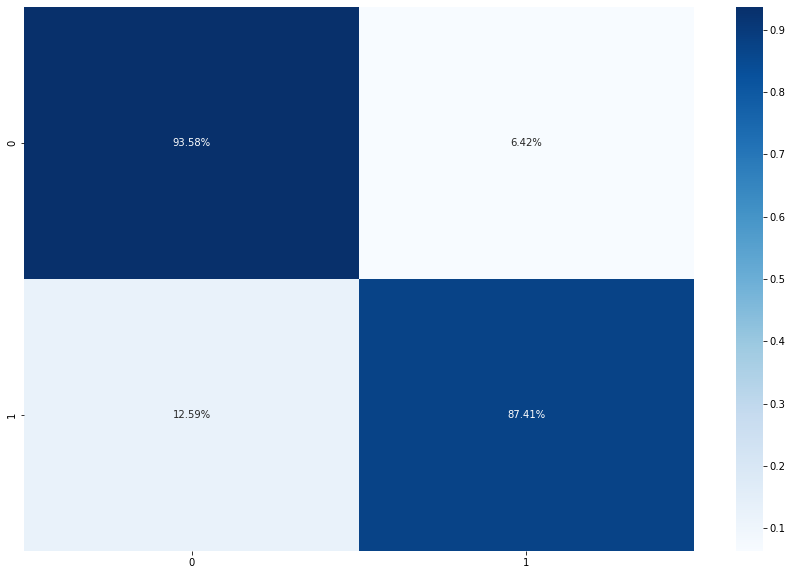

In [14]:
plt.figure(figsize=[15,10])
sns.heatmap(cnf_matrix_norm, annot=True, fmt='.2%', cmap='Blues')
plt.show()